# Perform a Maximum likelihood and MCMC analysis on a set of data

The model is a Sersic function.

In [1]:
# Importing modules

import sys,os,gzip, pickle
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
for axticks in ['xtick','ytick']:
    plt.rcParams['{:}.direction'.format(axticks)] = 'in'
    plt.rcParams['{:}.minor.visible'.format(axticks)] = True

from astropy import table
from astropy.table import Table
from astropy.modeling import models, fitting
from sklearn.neighbors import KernelDensity


In [2]:
# Read data 

rad_no_tbl = Table.read('rad_no.ecsv', format ='ascii.ecsv')
print(rad_no_tbl.colnames)

['GCC_group', 'Rproj', 'Nobs', 'Ncorr', 'area', 'rho', 'rho_upp_unc', 'rho_low_unc']


In [3]:
rad_no_tbl

GCC_group,Rproj,Nobs,Ncorr,area,rho,rho_upp_unc,rho_low_unc
,arcsec,,,arcsec2,1 / arcsec2,1 / arcsec2,1 / arcsec2
str18,float64,float64,float64,float64,float64,float64,float64
All,10.570719559235314,14.0,79.33138473116905,157.7940346056077,0.5027527493637568,0.25030065983976924,0.1878512095936409
All,15.631071285802566,26.0,125.06102651287357,336.83220727530795,0.371285832564864,0.1721172739056025,0.12124844032423299
All,23.1138843643216,43.0,176.19272988463388,878.9121738116639,0.20046682152611645,0.0895824680962624,0.060618615938120936
All,34.17882502363451,65.0,243.09669811204475,1988.3848975230133,0.12225837080882937,0.05354595245965785,0.035342369321750604
All,50.540707982571284,48.0,175.12152068588378,4288.421287342783,0.04083589483215013,0.018137284188477452,0.012183585025120595
All,74.73525381872152,36.0,130.98401146877075,5914.170843109538,0.02214748524239491,0.01000846143642101,0.006860718560221623
All,110.51206811927828,10.0,36.38108940828473,7390.03276304097,0.00492299433234367,0.002588373329126078,0.002018921417875525
Unresolved,10.570719559235314,8.0,45.332219846382316,157.7940346056077,0.2872872853507182,0.15772997035818923,0.12626995215012027


## Define the input data
Select a subset of the data to work on

In [4]:
[print(grp[:], end = ' ') for grp in rad_no_tbl['GCC_group']][0]

All All All All All All All Unresolved Unresolved Unresolved Unresolved Unresolved Unresolved Unresolved Partially resolved Partially resolved Partially resolved Partially resolved Partially resolved Partially resolved Partially resolved Extended Extended Extended Extended Extended Extended Extended Blue Blue Blue Blue Blue Blue Blue Red Red Red Red Red Red Red OMP OMP OMP OMP OMP OMP OMP OMR OMR OMR OMR OMR OMR OMR OM(P+R) OM(P+R) OM(P+R) OM(P+R) OM(P+R) OM(P+R) OM(P+R) IMR IMR IMR IMR IMR IMR IMR 

In [5]:
select = (rad_no_tbl['GCC_group'] == 'OMP')
select = (rad_no_tbl['GCC_group'] == 'OMR')
select = (rad_no_tbl['GCC_group'] == 'Blue')
select = (rad_no_tbl['GCC_group'] == 'Red')
select = (rad_no_tbl['GCC_group'] == 'IMR') & (rad_no_tbl['rho']>0.0)
select = (rad_no_tbl['GCC_group'] == 'All')
select = (rad_no_tbl['GCC_group'] == 'OM(P+R)')

x_ml = rad_no_tbl['Rproj'][select]

y_ml = rad_no_tbl['rho'][select]
y_err_ml = np.sqrt(rad_no_tbl['rho_upp_unc'][select]**2 + rad_no_tbl['rho_low_unc'][select]**2)

y_err_ml_upp = rad_no_tbl['rho_upp_unc']
y_err_ml_low = rad_no_tbl['rho_low_unc']


(0.0001, 0.7585775750291838)

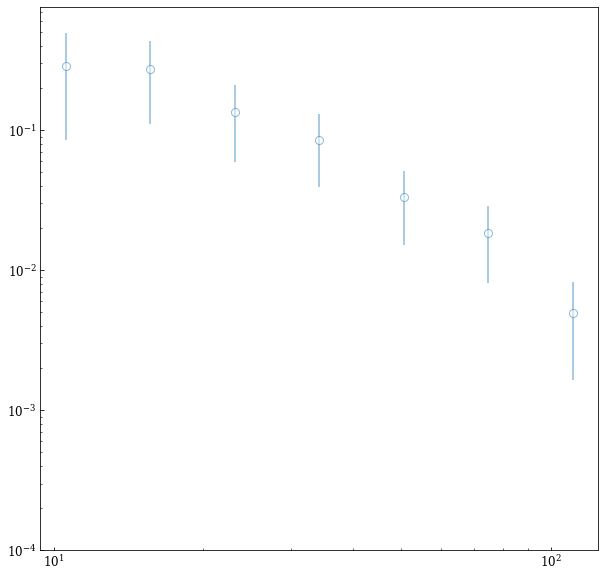

In [6]:
# Visualize the data

fig,ax = plt.subplots(figsize=(10,10))

for tx,ty,terr in zip(x_ml,y_ml,y_err_ml):
    ax.errorbar(tx, ty, yerr=terr, marker='o', mfc='white', ms=8, color='C0',
                label='Data', alpha=.5
               )
    
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(7,1.5e2)
ax.set_ylim(10**(-4),10**(-.12))


# Maximum Likelihood fitting and MCMC

In [7]:
import scipy
import scipy.optimize as op


## Define the model

In [8]:
def b_n_exact( n ):
    """Exact calculation of the Sersic derived parameter b_n, via solution
    of the function
            Gamma(2n) = 2 gamma_inc(2n, b_n)
    where Gamma = Gamma function and gamma_inc = lower incomplete gamma function.

    If n is a list or Numpy array, the return value is a 1-d Numpy array
    """
    import scipy
    from scipy.special import gamma as Gamma
    
    def gammainc_lower_scipy( z, b ):
        return scipy.special.gamma(z) * scipy.special.gammainc(z, b)
    GammaInc = gammainc_lower_scipy
    
    def myfunc(bn, n):
        return abs(float(2*GammaInc(2*n, bn) - Gamma(2*n)))
    if np.iterable(n):
        b = [scipy.optimize.brent(myfunc, (nn,)) for nn in n]
        b = np.array(b)
    else:
        b = scipy.optimize.brent(myfunc, (n,))
    return b

In [9]:
def Sersic(x, I_e, r_e, n):
    return I_e * np.exp( -b_n_exact(n)*(pow(x/r_e, 1.0/n) - 1.0) )

## Define likelihood function

In [10]:
def lnlike(theta, x, y, yerr):
    I_e, r_e, n, lnf = theta
    
    model = Sersic(x, I_e, r_e, n)
    
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 
                        + np.log(2*np.pi*inv_sigma2))
                )

In [11]:
# Make an initial guesses for the model parameters
# For this particular case, we set no additional error and rely fully on the 
# measurement uncertainties. But you can test by setting lnf_init>-3

I_e_init, r_e_init, n_init, lnf_init = 5e-2, 50.0, 1.5, -10

params_0 = [I_e_init, r_e_init, n_init, lnf_init]

nll = lambda *args: -lnlike(*args)
result = op.minimize(nll,
                     params_0,
                     args=(x_ml, y_ml, y_err_ml), method = 'L-BFGS-B' #SLSQP' #BFGS' #
                    )
if not(result['success']):
    print("Max likelihood failed.")
    print(result['message'])

ml_I_e, ml_r_e, ml_n, ml_lnf = result['x']
print('ml_I_e={:.2e}, ml_r_e={:.2f}, ml_n={:.2f}, lnf={:.2f}'.format(ml_I_e, ml_r_e, ml_n, ml_lnf))


ml_I_e=5.79e-02, ml_r_e=40.81, ml_n=1.76, lnf=-10.00


In [12]:
# Store the result in a list to pass
params_init = [val for val in [I_e_init, r_e_init, n_init]]
params_ml = result['x'][:-1]


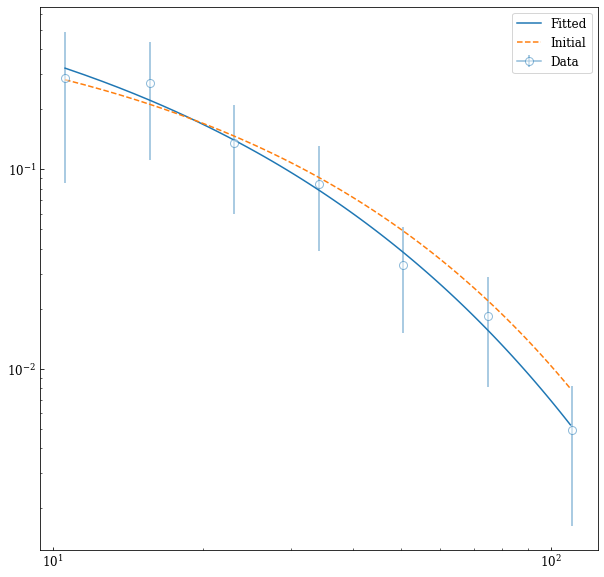

In [13]:
# Have a look at the ML fit

fig,ax = plt.subplots(figsize=(10,10))

for i,(tx,ty,terr) in enumerate(zip(x_ml,y_ml,y_err_ml)):
    if i==0:
        label = 'Data'
    else:
        label = ''
    ax.errorbar(tx, ty, yerr=terr, marker='o', mfc='white', ms=8, color='C0',
                label=label, alpha=0.5
               )
    
#for i,n in enumerate(y_ml):
#    ax.text(x_ml[i],np.log10(y_ml[i]*1.05), '{:}'.format(round(n)))

x_samples = np.arange(x_ml.min(),x_ml.max(),(x_ml.max()-x_ml.min())/100)
ax.plot(x_samples, Sersic(x_samples, *params_ml), '-', label='Fitted')
ax.plot(x_samples, Sersic(x_samples, *params_init), '--', label='Initial')

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend()

In [14]:
# Set priors for the fitted parameters

def lnprior(theta):
    I_e, r_e, n, lnf = theta
    if 1e-4 <= I_e <= .1 and 10. <= r_e <= 100 and 0.2<=n<=5. and -12.0 < lnf < -8:
        lnprior_val = 0.0
        return lnprior_val

    return -np.inf

In [15]:
def lnprob(theta, x, y, yerr):
    
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    try:
        lnprobval = lp
        if not np.any(np.isnan(lnlike(theta, x, y, yerr))):
            lnprobval = lp + lnlike(theta, x, y, yerr)
    except:
        lnprobval = lp + -np.inf
        
    return lnprobval


In [16]:
# Set up the MCMC chains
ndim = 4
nwalkers = 50
steps = 10000
nthreads = 4

In [17]:
# Initialize the walkers to the vicinity of the parameters. There are a few options.
# You can either start from the best fit ML, or from the initial values.

#pos = [result["x"] + 1e-1*np.random.randn(ndim) for i in range(nwalkers)]
pos = [np.array([I_e_init, r_e_init, n_init, lnf_init]) + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
#pos = [np.array([ml_I_e, ml_r_e, ml_n, ml_lnf]) + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]


In [18]:
import time 
import emcee
from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool,
                                    args=(x_ml, y_ml, y_err_ml))
    start = time.time()
    sampler.run_mcmc(pos, steps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))


100%|██████████| 10000/10000 [03:47<00:00, 43.93it/s]

Multiprocessing took 227.7 seconds


In [19]:
tau = sampler.get_autocorr_time()
print(tau)

[135.97144663 150.19419933  95.20913964  88.92618216]


In [20]:
# The acceptance rate should be between 0.3-0.5.

print("Mean acceptance rate is: {0:1.2f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance rate is: 0.44


In [ ]:
# (Optional) Save the sampler as a pickle

filename = 'rad_no_OMP_OMR_sampler_pickle.gz'

with gzip.open(filename, 'wb') as f:
    print('Compressing sampler to pickle file ... {:s}'.format(filename))
    pickle.dump(sampler, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# (OPTIONAL) Load the sampler from a saved pickle.

filename = 'rad_no_IMR_sampler_pickle.gz'

with gzip.open(filename, 'rb') as f:
    print('Decompressing the pickle file ... {:s}'.format(filename))
    sampler = pickle.load(f)
    

In [21]:
# Let's extract the chains

samples = sampler.chain

Text(0.5, 0, 'step')

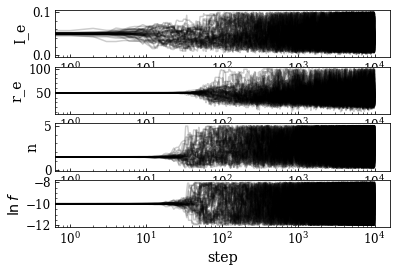

In [22]:
# Visualize the chains.

fig = plt.figure()
dim_name = [r'I_e', r'r_e', r'n', r'$\ln f$']

for dim in range(ndim):
    ax = fig.add_subplot(ndim, 1, dim+1)
    for i in range(nwalkers):
        ax.plot(np.arange(steps),
                samples[i, :, dim],
                ls='-',
                color='black',
                alpha=10./nwalkers,
                rasterized=True
               )
    ax.set_ylabel(dim_name[dim], fontsize='large')
    ax.set_xscale('log')
ax.set_xlabel('step', fontsize='large')

In [ ]:
filename = 'rho_OMP_OMR_Sersic_mcmc_steps_test.pdf'

fig.savefig('{:}'.format(filename), format='pdf', transparent=True,
            bbox_inches='tight', dpi=100
           )
os.system('pdfcrop {:} {:}'.format(filename,filename))

In [23]:
# Do a bit of cleaning
import gc, time
start = time.time()
gc.collect()
print('Cleaning duration {:.1f} seconds'.format(time.time()-start))

Cleaning duration 0.1 seconds


In [24]:
#It looks like the walkers have "burned in" by ~50-100 steps, so keep only those samples.

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
samples = sampler.chain[:, 50:, :ndim-1].reshape((-1, ndim-1)) # Use this if you want to avoid showing the lnf


In [25]:
# Limit by patrameter value
sample_limits_bl = False

Ie_low = samples[:,0].min() ; Ie_upp = .1 #samples[:,0].max() #
re_low = samples[:,1].min() ; re_upp = 150 #samples[:,1].max() #90
n_low = samples[:,2].min() ; n_upp = 3 #samples[:,2].max()

sample_lims = (samples[:,0]>Ie_low) & (samples[:,0]<Ie_upp) & \
                (samples[:,1]>re_low) & (samples[:,1]<re_upp) & \
                (samples[:,2]>n_low) & (samples[:,2]<n_upp)


if sample_limits_bl ==True:
    samples = samples[:,:][ sample_lims ]

In [26]:
# Show kde over the corner histograms?
show_kde = False

<Figure size 432x288 with 0 Axes>

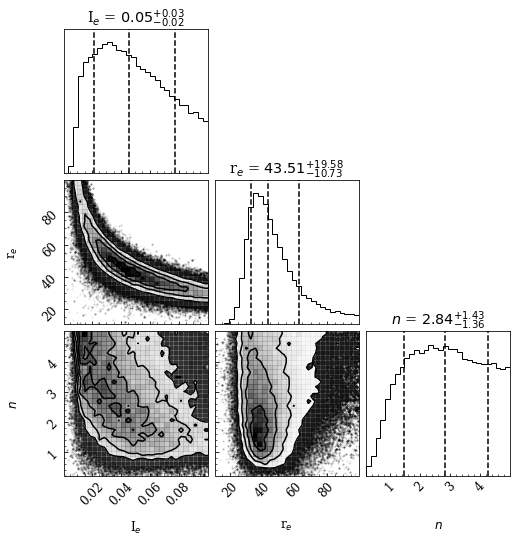

In [27]:
import corner
from sklearn.neighbors import KernelDensity

fig = plt.figure()
fig = corner.corner(samples,
                    labels=[r'I$_e$', r'r$_e$', r'$n$'], #r'$\ln f$'],
                    quantiles=[0.16, 0.5, 0.84], rasterized=True,
                    bins=30, #hist_bin_factor=2, 
                    show_titles=True)

if show_kde:
    #t_samples = sampler.chain[:, 50:, :ndim].reshape((-1, ndim)) # Use this if you want to avoid showing the lnf
    #if sample_limits_bl: t_samples = t_samples[ sample_lims ]
    #t_samples[:, ndim-1] = np.exp(t_samples[:, ndim-1])
    if samples.shape[1] == ndim: # If the lnf is not removed from the samples
        samples[:, ndim-1] = np.exp(samples[:, ndim-1])

    # Extract the axes
    axes = np.array(fig.axes).reshape((ndim-1, ndim-1))
    labels=[r'I$_e$', r'r$_e$', r'$n$']

    for alabel,dim in zip(labels,range(ndim-1)):
        #dim_samples = t_samples[:, dim]
        dim_samples = samples[:, dim]
        kde_bin = (np.nanmax(dim_samples)-np.nanmin(dim_samples))/30.

        X = dim_samples[:,None]

        print('KDE estimation with kde bin = {:.3f}'.format(kde_bin))
        kde = KernelDensity(kernel='gaussian', bandwidth=kde_bin).fit(X)

        print('KDE scores')
        samples_kde = np.linspace(X.min(),X.max(),100)
        log_dens_kde = kde.score_samples(samples_kde[:,None])

        samp_d = (X.max()-X.min())/100

        kde_xy = np.array([samples_kde, np.exp(log_dens_kde) * len(X) * samp_d * (100/30)])

        print('KDE peak = ', end ='')
        kde_y_max = np.nanmax(kde_xy[1])
        kde_peak = kde_xy[0][kde_xy[1] == kde_xy[1].max()][0]
        fwhm_low = 2*kde_peak/(kde_peak*.93)
        fwhm_upp = 2*kde_peak/(kde_peak*1.07)
        fwhm_peak_kde = kde_xy[0][(kde_xy[1] > kde_y_max/fwhm_low) & (kde_xy[1] < kde_y_max/fwhm_upp)]
        hwhm_peak_kde_low = kde_peak-fwhm_peak_kde.min()
        hwhm_peak_kde_upp = fwhm_peak_kde.max()-kde_peak
        print('{:.3f} +{:.3f}, -{:.3f}'.format(kde_peak,hwhm_peak_kde_upp,hwhm_peak_kde_low))
        dim_par_lab = r'{:} = {:.3f} $^{{+{:.3f}}}_{{-{:.3f}}}$'.format(alabel,kde_peak,hwhm_peak_kde_upp,abs(hwhm_peak_kde_low))

        # Loop over the diagonal
        ax = axes[dim, dim]
        ax.axvline(kde_peak, color='C0')
        ax.axvline(kde_peak-abs(hwhm_peak_kde_low), color='C0')
        ax.axvline(hwhm_peak_kde_upp+kde_peak, color='C0')
        ax.plot(kde_xy[0], kde_xy[1], '-', color='C0')
        ax.text((ax.get_xlim()[1]-ax.get_xlim()[0])*.5*.35,
                ax.get_ylim()[1]*1.22, '{:s}'.format(dim_par_lab), color='C0')

In [ ]:
filename = 'rho_OMP_OMR_mcmc_corner.pdf'

fig.savefig('{:}'.format(filename), format='pdf', transparent=True,
            bbox_inches='tight', dpi=100
           )
#os.system('pdfcrop {:} {:}'.format(filename,filename))

In [28]:
lb_use_params_mcmc_kde = False
params_mcmc_kde = [0.021, 45.356, 0.958]

In [29]:
# Print the MCMC parameters

samples = sampler.chain[:, 20:, :].reshape((-1, ndim))
samples[:, ndim-1] = np.exp(samples[:, ndim-1])
if sample_limits_bl ==True:
    samples = samples[:,:][ sample_lims ]
amplitude_mcmc, sigma_mcmc, mu_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                       zip(*np.percentile(samples, [16, 50, 84],
                                                          axis=0)))
#samples[:, 3] = np.exp(samples[:, 3])
I_e_mcmc, r_e_mcmc, n_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                       zip(*np.percentile(samples, [16, 50, 84],
                                                          axis=0)))
print("MCMC Parameter estimates:")
print("I_e:\t{:.2e}\t(+{:.2e}, -{:.2e}) [N/arcsec^2]".format(I_e_mcmc[0],
                                                        I_e_mcmc[1],
                                                        I_e_mcmc[2]))
print("r_e:\t{:.2f}\t(+{:.2f}, -{:.2f}) [arcsec]".format(r_e_mcmc[0],
                                              r_e_mcmc[1],
                                              r_e_mcmc[2]))
print("n:\t{:.2f}\t(+{:.2f}, -{:.2f})".format(n_mcmc[0],
                                            n_mcmc[1],
                                            n_mcmc[2]))

MCMC Parameter estimates:
I_e:	4.58e-02	(+3.13e-02, -2.42e-02) [N/arcsec^2]
r_e:	43.57	(+19.47, -10.78) [arcsec]
n:	2.83	(+1.43, -1.36)


In [30]:
print('I_0 = {:.2e}'.format(Sersic(0,I_e_mcmc[0],r_e_mcmc[0],n_mcmc[0])))

I_0 = 9.54e+00


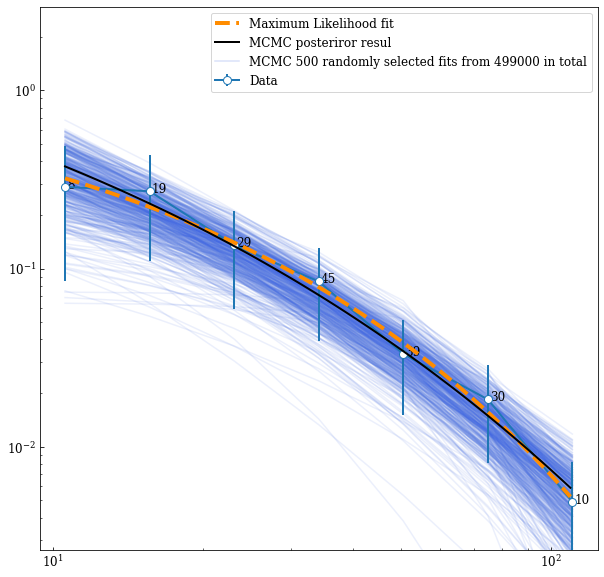

In [32]:
# Visualize the results
lb_show_init = False # Show the Initial expextation and ML fit?

n_fits = 500
plt_samples = samples

x_samples = np.arange(x_ml.min(),x_ml.max(),(x_ml.max()-x_ml.min())/100)
y_plt_ml = Sersic(x_samples, ml_I_e, ml_r_e, ml_n)
y_plt_mcmc = Sersic(x_samples, I_e_mcmc[0],r_e_mcmc[0],n_mcmc[0])
y_plt_mcmc_kde = Sersic(x_samples, *params_mcmc_kde)

fig,ax = plt.subplots(figsize=(10,10))

ax.errorbar(x_ml, y_ml, yerr=y_err_ml,
            marker='o', mfc='white', ms=8, lw=2,
            label='Data', zorder=n_fits-2, alpha=1
           )
for i,n in enumerate(rad_no_tbl['Nobs'][select]):
    ax.text(x_ml[i]*1.01,y_ml[i]*.98, '{:}'.format(round(n)))

ax.plot(x_samples, y_plt_ml, '--', color='darkorange', lw=4, zorder=n_fits-1,
        label='Maximum Likelihood fit')
ax.plot(x_samples, y_plt_mcmc, color='black', alpha=1, zorder=n_fits,
        lw=2, label='MCMC posteriror resul')
if lb_use_params_mcmc_kde:
    ax.plot(x_samples, y_plt_mcmc_kde, color='navy', alpha=1, zorder=n_fits,
            lw=2, label='MCMC posteriror KDE')

for i,(tI_e, tr_e, tn, tf) in enumerate(plt_samples[np.random.randint(len(plt_samples), size=n_fits)]):
    if i==0:
        ax.plot(x_ml, Sersic(x_ml, tI_e, tr_e, tn), color='royalblue', alpha=0.2, zorder=0,
                label='MCMC {:} randomly selected fits from {:} in total'.format(n_fits,round(samples.size/ndim))
               )
    else:
        ax.plot(x_ml, Sersic(x_ml, tI_e, tr_e, tn), color='royalblue', alpha=0.1, zorder=0)

ax.set_ylim(y_plt_ml.min()*.5,y_ml.max()*10**(1.01))
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [ ]:
filename = 'rho_OMP_OMR_Sersic_mcmc.pdf'

fig.savefig(filename, format='pdf', transparent=True,
            bbox_inches='tight', dpi=100
           )